In [1]:
import time
notebook_start_time = time.time()

# 0. Setup

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
from importlib.metadata import version
import torch

print("torch version:", version("torch"))

torch version: 2.6.0+cu124


In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7810aa179510>)

In [6]:
from gpt_download import download_and_load_gpt2
import torch
import torch.nn as nn
import numpy as np



class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector








class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits





def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [7]:
torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

# 1. Initialize DataLoaders

In [8]:
import tiktoken
import torch

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader


class GPT2DatasetV1(Dataset):
  def __init__(self,
               text,
               tokenizer,
               context_length, # length of each input vector
               stride # chunk the text into overlapping sequence of context_length
               ):
    self.input_id_vectors = []
    self.target_id_vectors = []

    # tokenize the entire text
    token_list = tokenizer.encode(text)

    # append input and target vectors
    for i in range(0, len(token_list) - context_length, stride):
      input_vector = token_list[i:i+context_length]
      target_vector = token_list[i+1:i+context_length+1]
      self.input_id_vectors.append(torch.tensor(input_vector))
      self.target_id_vectors.append(torch.tensor(target_vector))

  # get the number of input vectors
  def __len__(self):
    return len(self.input_id_vectors)

  # return the (input vector, target vector) pair
  def __getitem__(self, id):
    return self.input_id_vectors[id], self.target_id_vectors[id]



def create_dataloader_V1(text,
                 batch_size=4,
                 context_length=256,
                 stride=128,
                 shuffle=True, # shuffle dataset
                 drop_last=True, # drop last batch if it not equal required size
                 num_workers=0 # number of CPU processes for preprocessing
                 ):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPT2DatasetV1(text=text,
                          tokenizer=tokenizer,
                          context_length=context_length,
                          stride=stride)

  dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          drop_last=drop_last,
                          num_workers=num_workers)

  return dataloader

In [9]:
# setup
bpe_tokenizer = tiktoken.get_encoding("gpt2")


file_path = "war_and_peace.txt" #"the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
  text = f.read()

total_characters = len(text)
total_tokens = len(bpe_tokenizer.encode(text))
print(f"total characters: {total_characters}")
print(f"total tokens: {total_tokens}")

total characters: 3227520
total tokens: 853923


In [10]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text))


torch.manual_seed(123)

train_loader = create_dataloader_V1(
    text[:split_idx],
    batch_size=2,
    context_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_V1(
    text[split_idx:],
    batch_size=2,
    context_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# 2. Learning rate warmup

In [11]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

In [12]:
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

4539


In [13]:
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr

        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

        # Calculate loss and update weights
        # ...

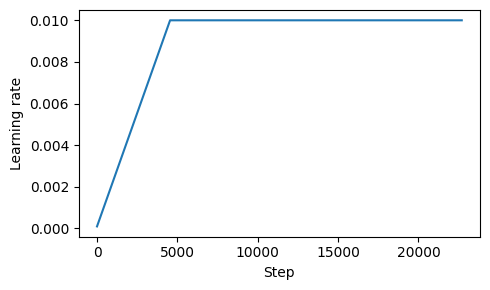

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("warmup_lr.pdf")
plt.show()

# 3. Cosine Decay

$$
\boxed{
\operatorname{lr}(g)=
\text{min_lr}+
\frac{\text{peak_lr}-\text{min_lr}}{2}\,
\Bigl(
1+\cos\!\bigl(
\pi \,\frac{g-\text{warmup_steps}}
{\text{total_training_steps}-\text{warmup_steps}}
\bigr)
\Bigr)
}
$$


In [15]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # Adjust the learning rate based on the current phase (warmup or cosine annealing)
        if global_step < warmup_steps:
            # Linear warmup
            lr = initial_lr + global_step * lr_increment
        else:
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) /
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress))

        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

        # Calculate loss and update weights

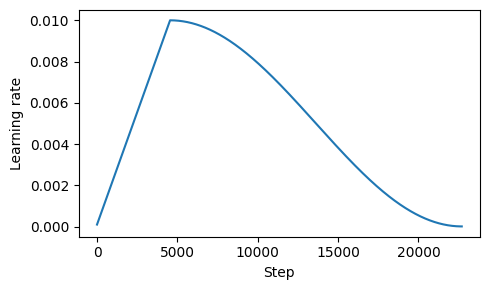

In [16]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("warmup_plus_cosine_decay_lr.pdf")
plt.show()

# 4. Gradient Clipping

- By setting a threshold, gradients exceeding this limit are scaled down to a maximum magnitude to ensure that the updates to the model's parameters during backpropagation remain within a manageable range
- For instance, using the `max_norm=1.0` setting in PyTorch's `clip_grad_norm_` method means that the norm of the gradients is clipped such that their maximum norm does not exceed 1.0

In [17]:
def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss

In [18]:
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [19]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0520, device='cuda:0')


- Applying gradient clipping, we can see that the largest gradient is now substantially smaller:

In [20]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0220, device='cuda:0')


# 5. The modified training function

In [21]:
import torch

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text

In [22]:
def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [23]:
def generate_text_simple(model,
                         input_batch,  # [batch, num_tokens]
                         max_new_tokens,  # numbers of new tokens to be predicted
                         context_size):
    for _ in range(max_new_tokens):
        # crop current context if it exceeds the supported context_size
        crop_input_batch = input_batch[:, -context_size:]

        # predict next token
        with torch.no_grad():
            logits = model(crop_input_batch)

        # consider only logits of the last token
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # update input_batch (append predicted tokens to the sequences)
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)  # [batch, num_tokens+1]

    return input_batch


def generate_text_advanced(model,
                           input_batch,
                           max_new_tokens,
                           context_size,
                           temperature=1.0,
                           top_k=None,
                           top_p=None,
                           repetition_penalty=1.0,
                           eos_id=None):
    """
    Advanced text generation with multiple decoding strategies.

    Args:
        model: The language model
        input_batch: Input token ids [batch_size, seq_len]
        max_new_tokens: Number of tokens to generate
        context_size: Maximum context length the model can handle
        temperature: Sampling temperature (1.0 = neutral, <1.0 = more focused, >1.0 = more random)
        top_k: If set, only sample from the top k most likely tokens
        top_p: If set, sample from the smallest set of tokens whose cumulative probability exceeds p
        repetition_penalty: Penalty for repeating tokens (1.0 = no penalty, >1.0 = penalize repetitions)
        eos_id: Optional end of sequence token id to stop generation early

    Returns:
        Tensor of generated token ids [batch_size, seq_len + max_new_tokens]
    """
    for _ in range(max_new_tokens):
        # Crop context if needed
        crop_input_batch = input_batch[:, -context_size:]

        # Get model predictions
        with torch.no_grad():
            logits = model(crop_input_batch)

        # Consider only the last token's logits
        logits = logits[:, -1, :]  # [batch_size, vocab_size]

        # Apply repetition penalty
        if repetition_penalty != 1.0:
            # Get unique tokens in the input
            used_tokens = torch.unique(input_batch)
            # Penalize previously used tokens
            logits.index_fill_(dim=-1, index=used_tokens,
                               value=logits.index_select(dim=-1, index=used_tokens) / repetition_penalty)

        # Apply temperature scaling
        if temperature != 1.0:
            logits = logits / temperature

        # Convert to probabilities
        probas = torch.softmax(logits, dim=-1)

        # Apply top-k filtering
        if top_k is not None:
            top_k = min(top_k, logits.size(-1))
            top_logits, top_indices = torch.topk(logits, top_k)
            # Create a mask for non-top-k values
            mask = torch.zeros_like(logits).scatter_(dim=-1, index=top_indices, value=1)
            # Set non-top-k values to -inf before softmax
            logits = torch.where(mask > 0, logits, torch.tensor(-float('inf')).to(logits.device))
            # Recompute probabilities
            probas = torch.softmax(logits, dim=-1)

        # Apply nucleus (top-p) sampling
        if top_p is not None:
            sorted_probas, sorted_indices = torch.sort(probas, descending=True)
            cumsum_probas = torch.cumsum(sorted_probas, dim=-1)
            # Remove tokens after cumsum exceeds top_p
            mask = cumsum_probas <= top_p
            # Always keep at least one token
            mask[..., 0] = True
            sorted_indices = sorted_indices[mask]
            probas = torch.zeros_like(probas).scatter_(-1, sorted_indices, sorted_probas[mask])
            probas.div_(probas.sum(dim=-1, keepdim=True))

        # Sample next token
        predicted_tokens = torch.multinomial(probas, num_samples=1)

        # Stop if EOS token is generated
        if eos_id is not None and (predicted_tokens == eos_id).any():
            break

        # Append prediction to input
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)

    return input_batch

In [24]:
def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model back to training mode
  model.train()
  return train_loss, val_loss


def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
  # set model back to training mode
  model.train()

- Now let's add the three concepts covered above to the `train_model_simple` function to create the more sophisticated `train_model` function below:

In [25]:
ORIG_BOOK_VERSION = False



def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                device,
                n_epochs,
                eval_freq,
                eval_iter,
                start_context,
                tokenizer,
                warmup_steps,
                initial_lr=3e-05,
                min_lr=1e-6):

  train_losses, val_losses = [], []
  track_tokens_seen, track_lrs = [], []

  token_seen = 0
  global_step = -1

  # retrieve the maximum/peak learning rate from the optimizer
  peak_lr = optimizer.param_groups[0]["lr"]

  # calculate the total number of iterations in the training process
  total_training_steps = len(train_loader) * n_epochs

  # calculate the learning rate increment during the warmup phase
  lr_increment = (peak_lr - initial_lr) / warmup_steps

  for epoch in range(n_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      global_step += 1

      # adjust the learning rate based on the current phase (warmup or cosine)
      if global_step < warmup_steps:
        lr = initial_lr + global_step * lr_increment
      else:
        # cosine annealing after warmup
        progress = ((global_step - warmup_steps) /
                    (total_training_steps - warmup_steps))
        lr = (min_lr +
         (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress)))

      # apply the calculated learning rate to the optimizer
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      track_lrs.append(lr) # store the current learning rate

      # calculate and backpropagate the loss
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      loss.backward()

      # apply gradient clipping after the warmup phase to avoid exploding gradients
      if ORIG_BOOK_VERSION:
        if global_step > warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      else:
        # the book originally used global_step > warmup_steps, which led to a skipped clipping step after warmup
        if global_step >= warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()
      token_seen += input_batch.numel()

      # periodically evaluate the model on the training and validation sets
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print the current losses
        print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

    # generate and print a sample from the model to monitor progess
    generate_and_print_sample(
        model=model,
        tokenizer=tokenizer,
        device=device,
        start_context=start_context
    )

  return train_losses, val_losses, track_tokens_seen, track_lrs

In [26]:
import tiktoken


import time
start_time = time.time()

torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 5
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="In the midst of winter",
    tokenizer=tokenizer, warmup_steps=warmup_steps,
    initial_lr=1e-5, min_lr=1e-5
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Iter 000000): Train loss 10.911, Val loss 10.889
Ep 1 (Iter 000005): Train loss 10.639, Val loss 10.609
Ep 1 (Iter 000010): Train loss 10.250, Val loss 10.283
Ep 1 (Iter 000015): Train loss 9.895, Val loss 9.938
Ep 1 (Iter 000020): Train loss 9.671, Val loss 9.634
Ep 1 (Iter 000025): Train loss 9.391, Val loss 9.396
Ep 1 (Iter 000030): Train loss 9.059, Val loss 9.201
Ep 1 (Iter 000035): Train loss 9.222, Val loss 9.039
Ep 1 (Iter 000040): Train loss 9.014, Val loss 8.911
Ep 1 (Iter 000045): Train loss 8.968, Val loss 8.791
Ep 1 (Iter 000050): Train loss 8.987, Val loss 8.686
Ep 1 (Iter 000055): Train loss 8.616, Val loss 8.588
Ep 1 (Iter 000060): Train loss 8.499, Val loss 8.477
Ep 1 (Iter 000065): Train loss 8.456, Val loss 8.365
Ep 1 (Iter 000070): Train loss 8.419, Val loss 8.261
Ep 1 (Iter 000075): Train loss 8.223, Val loss 8.160
Ep 1 (Iter 000080): Train loss 8.287, Val loss 8.054
Ep 1 (Iter 000085): Train loss 7.972, Val loss 7.953
Ep 1 (Iter 000090): Train loss 7.952, Va

- Let's see whether the learning rate behaves as intended:

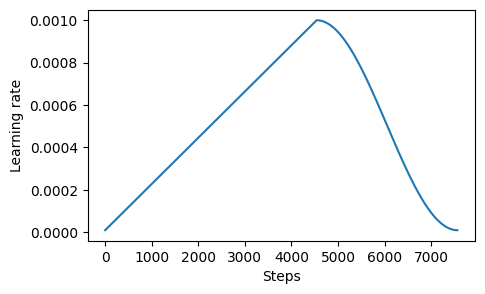

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

- Let's plot the losses:

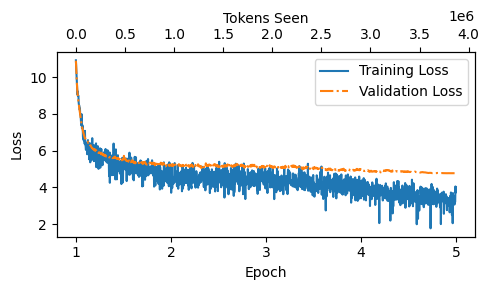

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epoch_seen,
                tokens_seen,
                train_losses,
                val_losses,
                fig_path="loss_plot.pdf"):
  """Plot training and validation loss."""

  fig, ax1 = plt.subplots(figsize=(5, 3))

  # plot training and validation loss against epochs
  ax1.plot(epoch_seen, train_losses, label="Training Loss")
  ax1.plot(epoch_seen, val_losses, linestyle="-.", label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # create a second x-axis for token seen
  ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout() # adjust layout to make room
  plt.savefig(fig_path)
  plt.show()





epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("loss_curves.pdf")
plt.show()

In [29]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 8 min 41.55 sec
